In [1]:
load("dataset_inf.Rdata")

In [2]:
ls()

[1] "cpi"            "fake.testing.X" "ppi"            "X"

### A. Conduct a Principal Component Analysis at first.

In [3]:
#use all data to do PCA
scale_X=scale(X[,-1])
xpca=prcomp(scale_X)
xdir=as.data.frame(predict(xpca))

#### The first 4 loadings already feature a lot among the data set.

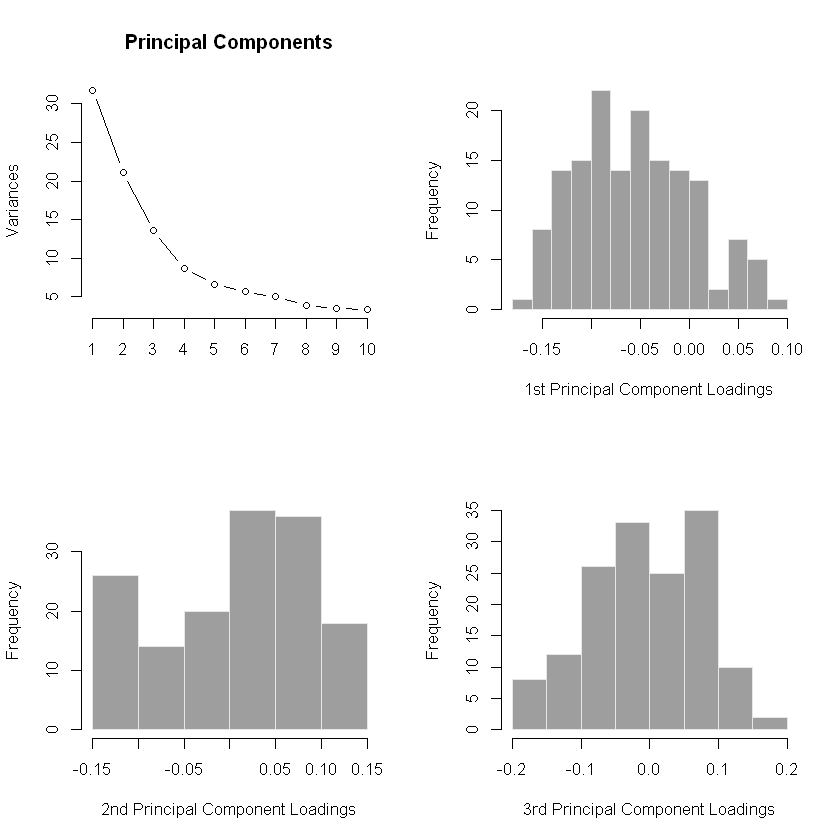

In [4]:
par(mfrow=c(2,2))
loadings=xpca$rotation
plot(xpca,type = "l", main ="Principal Components")
hist(loadings[,1], main="", xlab="1st Principal Component Loadings",
     col=8, border=grey(.9))
hist(loadings[,2], main="", xlab="2nd Principal Component Loadings",
     col=8, border=grey(.9))
hist(loadings[,3], main="", xlab="3rd Principal Component Loadings",
     col=8, border=grey(.9))

#### High loadings in PC1 are similar. They all indicate a price factor. High loadings in PC2 are similar too, which all indicate an interest rate factor.
#### This makes sence because firstly price is the key to the inflation, and secondly interest rate would influence the inflation. Remember a lot of economic theories explain the relationship between inflation and interest rate.
#### However, when it comes to PC3, it is hard to conclude any common feature from the high loadings.

In [5]:
head(as.data.frame(loadings[order(abs(loadings[,1]),decreasing=TRUE),1]))
head(as.data.frame(loadings[order(abs(loadings[,2]),decreasing=TRUE),2]))
head(as.data.frame(loadings[order(abs(loadings[,3]),decreasing=TRUE),3]))

,"loadings[order(abs(loadings[, 1]), decreasing = TRUE), 1]"
,<dbl>
企业商品价格指数上年同期100_矿产品_当期,-0.1615486
企业商品价格指数上年同期100_当期,-0.1565425
国房景气指数_当期,-0.1519678
工业生产者出厂价格指数上年同期100_原料_当期,-0.1510111
规模以上工业增加值_当期同比实际增速,-0.1468754
工业生产者出厂价格指数上年同期100_当期,-0.1464410


,"loadings[order(abs(loadings[, 2]), decreasing = TRUE), 2]"
,<dbl>
工业生产者购进价格指数上年同期100_木材及纸浆类_当期,-0.1471566
中债银行间债券总指数收益率,-0.1471133
中债固定利率债券指数收益率,-0.1469681
中债中短期债券指数收益率,-0.1459921
中债综合指数收益率,-0.1459845
中债国债到期收益率3年_一阶差分,0.1453954


,"loadings[order(abs(loadings[, 3]), decreasing = TRUE), 3]"
,<dbl>
金融机构人民币各项存款_期末同比增速,-0.1950442
货币和准货币M2_期末同比增速,-0.1801703
居民消费价格指数上年同期100_衣着_当期,0.1705012
社会融资规模存量同比增速,-0.1664006
固定资产投资完成额不含农户_当期实际同比增速,-0.1609939
期货成交量_上海期货交易所_当期同比增速,-0.1587762


#### It is more clear if the observations are plotted by groups. In the left graph, the observations are divided by the mean of a price variable, and in the right graph, divided by the mean of an interest rate variable.

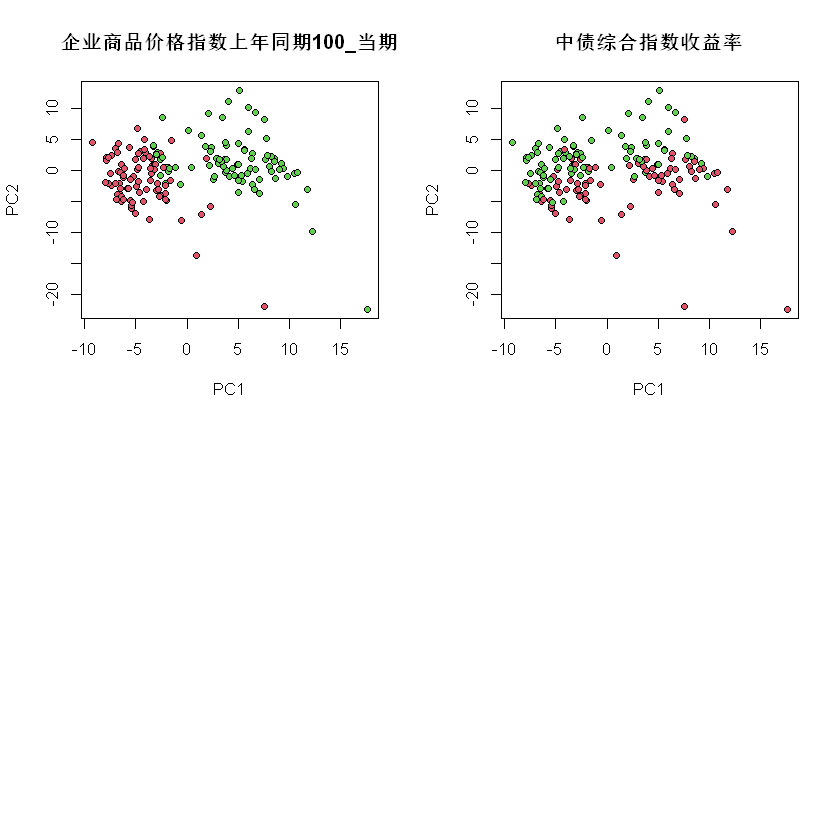

In [6]:
f1=scale_X[,'企业商品价格指数上年同期100_当期']
m_f1=mean(f1)
f2=scale_X[,'中债综合指数收益率']
m_f2=mean(f2)
par(mfrow=c(2,2))
plot(xdir[,1:2], pch=21,bg=(c(2,3))[factor(f1<m_f1)], main="企业商品价格指数上年同期100_当期")
plot(xdir[,1:2], pch=21,bg=(c(2,3))[factor(f2<m_f2)], main="中债综合指数收益率")

### B. Fit a time series factor model 

#### Data preparation
##### Since the useful cpi and ppi number is 144 (period 25 to 168 since we need lag 12), we partition the data into 10 different data to conduct time series cross validation. For example, train data 1:108 and test data 109:135; train data 2:109 and test data 110:136; e.g.

In [7]:
lncpi=log(cpi[13:168,2])-log(cpi[1:156,2])
lnppi=log(ppi[13:168,2])-log(ppi[1:156,2])

cpi_t=lncpi[13:156]
cpi_t_1=lncpi[12:155]
cpi_t_2=lncpi[11:154]
cpi_t_12=lncpi[1:144]

ppi_t=lnppi[13:156]
ppi_t_1=lnppi[12:155]
ppi_t_2=lnppi[11:154]
ppi_t_12=lnppi[1:144]

In [8]:
table_best=function(table_oosr2){
    best_pc_cpi=rep(0,t)
    best_pc_ppi=rep(0,t)
    best_oosr2_cpi=rep(0,t)
    best_oosr2_ppi=rep(0,t)
    for (i in 1:t){
        temp=table_oosr2[table_oosr2[,'#CV']==i,]
        n=which.max(temp[,3])
        best_pc_cpi[i]=temp[n,'#PC']
        best_oosr2_cpi[i]=best_oosr2_cpi[i]+temp[n,3]
    
        temp=table_oosr2[table_oosr2[,'#CV']==i,]
        n=which.max(temp[,4])
        best_pc_ppi[i]=temp[n,'#PC']
        best_oosr2_ppi[i]=best_oosr2_ppi[i]+temp[n,4]
        }
    cpi_best=cbind(best_pc_cpi,best_oosr2_cpi)
    ppi_best=cbind(best_pc_ppi,best_oosr2_ppi)
    table_best=cbind(cpi_best,ppi_best)
    table_best=cbind('#CV'=seq(1,t),table_best)
    return(table_best)
    }

#### When fitting the model, 3 main problems appear.

##### 1st Problem: Different PC numbers give VERY different outcomes.
##### 2nd Problem: Different train sets give VERY different outcomes.

##### Under basic model:
##### $$ y_t=\alpha+\beta X_t+e$$
##### where the dimension of $X_t$ is reduced by PCA.

In [9]:
#For Pb1:
k=100 #max PC number
l=2 #min PC number
#For Pb2:
s=107 #partition train data from 1:s+1, test set from s+2:135
      #better no more than 107 since 135X0.8=108
OOSR2_cpi_fun=function(fit){
    var_test_cpi_t=var(test_cpi_t)
    test_data=test_X_t
    colnames(test_data)=seq(1,j)
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_cpi_t-pred_y)/var_test_cpi_t
    return(OOSR2)
    }

OOSR2_ppi_fun=function(fit){
    var_test_ppi_t=var(test_ppi_t)
    test_data=test_X_t
    colnames(test_data)=seq(1,j)
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_ppi_t-pred_y)/var_test_ppi_t
    return(OOSR2)
    }

v_oosr2_cpi=rep(0,k-l+1)
v_oosr2_ppi=rep(0,k-l+1)
table_oosr2=data.frame()
X_t=predict(prcomp(scale(X[25:168,-1])))
t=10 #CV number
for (i in 1:t){
    for (j in l:k){
        #train data
        e=i+s
        train_cpi_t=cpi_t[i:e]
        train_ppi_t=ppi_t[i:e]
        
        train_X_t=X_t[i:e,1:j]
    
        #test data
        f=e+1
        g=i+134
        test_cpi_t=cpi_t[f:g]
        test_ppi_t=ppi_t[f:g]
        
        test_X_t=X_t[f:g,1:j]

        #fit model
        train_data=train_X_t
        colnames(train_data)=seq(1,j)
        fit_cpi <- glm(train_cpi_t ~ ., data=as.data.frame(train_data))
    
        train_data=train_X_t
        colnames(train_data)=seq(1,j)
        fit_ppi <- glm(train_ppi_t ~ ., data=as.data.frame(train_data))
    
        #calculate oosr2
        u=j-l+1
        v_oosr2_cpi[u] = OOSR2_cpi_fun(fit_cpi)
        v_oosr2_ppi[u] = OOSR2_ppi_fun(fit_ppi)
    }
    value=cbind(v_oosr2_cpi,v_oosr2_ppi)
    number=cbind('#CV'=rep(i,k-l+1),'#PC'=seq(l,k))
    temp=cbind(number,value)
    table_oosr2=rbind(table_oosr2,temp)
}

table_best(table_oosr2)

#CV,best_pc_cpi,best_oosr2_cpi,best_pc_ppi,best_oosr2_ppi
1,52,0.062958897,3,0.5949628
2,53,0.016683108,3,0.5512692
3,54,0.001233880,22,0.5480883
4,54,-0.043828469,21,0.5933749
5,54,-0.060625293,21,0.6457537
6,54,-0.002656752,21,0.6955670
7,54,0.016477799,21,0.7644020
8,54,0.172945801,32,0.8278961
9,54,0.302561335,32,0.8735299
10,56,0.277399806,32,0.9016391


##### We can see from the table above that different PC numbers and different train sets would all result in very different outcomes.

##### 3rd Problem: Different lags give VERY different outcomes.

##### Under model:
##### $$ y_t=\alpha+\gamma y_{t-1}+\beta X_t+e$$
##### where the dimension of $X_t$ is reduced by PCA, for each $\hat{y}_{t+1}$, using predicted $ \hat{y}_{t} $ as the AR1 variable.
##### Repeat the above steps.

In [10]:
#For Pb1:
k=100 #max PC number
l=2 #min PC number
#For Pb2:
s=107 #partition train data from 1:s+1, test set from s+2:135
      #better no more than 107 since 135X0.8=108
OOSR2_cpi_fun=function(fit){
    h=135-s-1
    pred_cpi_t=rep(0,h)
    temp_yt1=cpi_t[e]
    for (i in 1:h){
        pred_X=predict(xpca,test_X_t[i,])[,1:j]
        test_data=cbind('yt-1'=temp_yt1,t(pred_X))
        pred_cpi_t[i]=predict(fit_cpi,as.data.frame(test_data))
        temp_yt1=pred_cpi_t[i]
    }
    
    var_test_cpi_t=var(test_cpi_t)
    OOSR2=1-var(test_cpi_t-pred_cpi_t)/var_test_cpi_t
    return(OOSR2)
    }
    
OOSR2_ppi_fun=function(fit){
    h=135-s-1
    pred_ppi_t=rep(0,h)
    temp_yt1=ppi_t[e]
    for (i in 1:h){
        pred_X=predict(xpca,test_X_t[i,])[,1:j]
        test_data=cbind('yt-1'=temp_yt1,t(pred_X))
        pred_ppi_t[i]=predict(fit_ppi,as.data.frame(test_data))
        temp_yt1=pred_ppi_t[i]
    }
    
    var_test_ppi_t=var(test_ppi_t)
    OOSR2=1-var(test_ppi_t-pred_ppi_t)/var_test_ppi_t
    return(OOSR2)
    }
    
v_oosr2_cpi=rep(0,k-l+1)
v_oosr2_ppi=rep(0,k-l+1)
table_oosr2=data.frame()
X_t=X[25:168,-1]
t=10 #CV number
for (i in 1:t){
    #train data
    e=i+s
    xpca=prcomp(scale(X_t[i:e,-1]))
    xdir=predict(xpca)
    train_cpi_t=cpi_t[i:e]
    train_cpi_t_1=cpi_t_1[i:e]
    train_ppi_t=ppi_t[i:e]
    train_ppi_t_1=ppi_t_1[i:e]
    
    for (j in l:k){
        train_X_t=xdir[,1:j]
        #test data
        f=e+1
        g=i+134
        test_cpi_t=cpi_t[f:g]
        test_ppi_t=ppi_t[f:g]
        test_X_t=X_t[f:g,]
        
        #fit model
        train_data=cbind('yt-1'=train_cpi_t_1,train_X_t)
        fit_cpi <- glm(train_cpi_t ~ ., data=as.data.frame(train_data))
    
        train_data=cbind('yt-1'=train_ppi_t_1,train_X_t)
        fit_ppi <- glm(train_ppi_t ~ ., data=as.data.frame(train_data))
        
        #calculate oosr2
        u=j-l+1
        v_oosr2_cpi[u] = OOSR2_cpi_fun(fit_cpi)
        v_oosr2_ppi[u] = OOSR2_ppi_fun(fit_ppi)
    }
    value=cbind(v_oosr2_cpi,v_oosr2_ppi)
    number=cbind('#CV'=rep(i,k-l+1),'#PC'=seq(l,k))
    temp=cbind(number,value)
    table_oosr2=rbind(table_oosr2,temp)
}

table_best(table_oosr2)

#CV,best_pc_cpi,best_oosr2_cpi,best_pc_ppi,best_oosr2_ppi
1,89,-3.8526945860,5,0.02002734
2,89,-8.3439963794,3,-0.09112098
3,3,-0.9182839455,4,0.08433274
4,100,-2.0322984645,7,-0.39692220
5,99,-0.9043796699,7,-1.95702379
6,7,-0.8166398980,3,-3.59144144
7,99,-0.8676568883,22,0.41061688
8,99,-0.2837312373,22,0.75246969
9,96,-0.2660381313,21,0.84749877
10,5,0.0006310613,23,0.84602398


##### The outcome is getting worse. So we don't think it is good to use AR1 since we would use predicted value to predict.

##### Under model:
##### $$ y_t=\alpha+\beta_1 X_t+\beta_2 X_{t-12}+e$$
##### where first cbind $X_t$ and $X_{t-12}$, and then reduce the dimension of by PCA.
##### We use both OLS and Random Forest to fit the factor model.

In [11]:
library(randomForest)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



In [12]:
#For Pb1:
k=100 #max PC number
l=2 #min PC number
#For Pb2:
s=107 #partition train data from 1:s+1, test set from s+2:135
      #better no more than 107 since 135X0.8=108
OOSR2_cpi_fun=function(fit){
    var_test_cpi_t=var(test_cpi_t)
    test_data=test_X_t
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_cpi_t-pred_y)/var_test_cpi_t
    return(OOSR2)
    }

OOSR2_ppi_fun=function(fit){
    var_test_ppi_t=var(test_ppi_t)
    test_data=test_X_t
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_ppi_t-pred_y)/var_test_ppi_t
    return(OOSR2)
    }

v_oosr2_cpi=rep(0,k-l+1)
v_oosr2_ppi=rep(0,k-l+1)
rf_oosr2_cpi=rep(0,k-l+1)
rf_oosr2_ppi=rep(0,k-l+1)

table_oosr2_ols=data.frame()
table_oosr2_rf=data.frame()

X_t=predict(prcomp(scale(cbind(X[25:168,-1],X[13:156,-1]))))
t=10 #CV number
for (i in 1:t){
    for (j in l:k){
        #train data
        e=i+s
        train_cpi_t=cpi_t[i:e]
        train_ppi_t=ppi_t[i:e]
        
        train_X_t=X_t[i:e,1:j]
    
        #test data
        f=e+1
        g=i+134
        test_cpi_t=cpi_t[f:g]
        test_ppi_t=ppi_t[f:g]
        
        test_X_t=X_t[f:g,1:j]

        #fit model
        train_data=train_X_t
        
        fit_cpi <- glm(train_cpi_t ~ ., data=as.data.frame(train_data))
        fit_ppi <- glm(train_ppi_t ~ ., data=as.data.frame(train_data))
        
        rf_cpi <- randomForest(train_cpi_t ~ ., data=as.data.frame(train_data))
        rf_ppi <- randomForest(train_ppi_t ~ ., data=as.data.frame(train_data))
        
        #calculate oosr2
        u=j-l+1
        v_oosr2_cpi[u] = OOSR2_cpi_fun(fit_cpi)
        v_oosr2_ppi[u] = OOSR2_ppi_fun(fit_ppi)
        
        rf_oosr2_cpi[u] = OOSR2_cpi_fun(rf_cpi)
        rf_oosr2_ppi[u] = OOSR2_ppi_fun(rf_ppi)
        
    }
    value=cbind(v_oosr2_cpi,v_oosr2_ppi)
    number=cbind('#CV'=rep(i,k-l+1),'#PC'=seq(l,k))
    temp=cbind(number,value)
    table_oosr2_ols=rbind(table_oosr2_ols,temp)
    
    value=cbind(rf_oosr2_cpi,rf_oosr2_ppi)
    temp=cbind(number,value)
    table_oosr2_rf=rbind(table_oosr2_rf,temp)
}

table_best(table_oosr2_ols)
table_best(table_oosr2_rf)

#CV,best_pc_cpi,best_oosr2_cpi,best_pc_ppi,best_oosr2_ppi
1,58,0.3834204,40,0.9208017
2,58,0.4359224,44,0.9185875
3,59,0.4393418,44,0.9190998
4,59,0.4269779,43,0.9178469
5,60,0.3985725,43,0.9257458
6,59,0.3457073,47,0.9465313
7,59,0.3829022,60,0.9639440
8,59,0.4172123,59,0.9724432
9,59,0.4232951,71,0.9758013
10,73,0.2973776,47,0.9734390


#CV,best_pc_cpi,best_oosr2_cpi,best_pc_ppi,best_oosr2_ppi
1,4,-0.29394391,3,0.2857552
2,5,-0.16788227,3,0.2526062
3,5,-0.06192212,3,0.2254426
4,3,-0.16679885,3,0.2067899
5,4,-0.07671133,3,0.2155045
6,4,-0.13676166,3,0.2182890
7,5,0.10569185,33,0.2200247
8,5,0.23911793,4,0.1899190
9,5,0.33664279,3,0.2321367
10,4,0.46377466,3,0.3365364


##### It is clearly that Random Forest outcome is worse than ols.

##### Under model:
##### $$ y_t=\alpha+\beta_1 X_t+\beta_2 X_{t-1} +\beta_3 X_{t-12}+e$$
##### where first cbind $X_t$, $X_{t-1}$ and $X_{t-12}$, and then reduce the dimension of by PCA.
##### This time we only do OLS.

In [13]:
#For Pb1:
k=100 #max PC number
l=2 #min PC number
#For Pb2:
s=107 #partition train data from 1:s+1, test set from s+2:135
      #better no more than 107 since 135X0.8=108
OOSR2_cpi_fun=function(fit){
    var_test_cpi_t=var(test_cpi_t)
    test_data=test_X_t
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_cpi_t-pred_y)/var_test_cpi_t
    return(OOSR2)
    }

OOSR2_ppi_fun=function(fit){
    var_test_ppi_t=var(test_ppi_t)
    test_data=test_X_t
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_ppi_t-pred_y)/var_test_ppi_t
    return(OOSR2)
    }

v_oosr2_cpi=rep(0,k-l+1)
v_oosr2_ppi=rep(0,k-l+1)

table_oosr2_ols=data.frame()

X_temp=cbind(X[25:168,-1],X[24:167,-1])
X_t=predict(prcomp(scale(cbind(X_temp,X[13:156,-1]))))
t=10 #CV number
for (i in 1:t){
    for (j in l:k){
        #train data
        e=i+s
        train_cpi_t=cpi_t[i:e]
        train_ppi_t=ppi_t[i:e]
        
        train_X_t=X_t[i:e,1:j]
    
        #test data
        f=e+1
        g=i+134
        test_cpi_t=cpi_t[f:g]
        test_ppi_t=ppi_t[f:g]
        
        test_X_t=X_t[f:g,1:j]

        #fit model
        train_data=train_X_t
        
        fit_cpi <- glm(train_cpi_t ~ ., data=as.data.frame(train_data))
        fit_ppi <- glm(train_ppi_t ~ ., data=as.data.frame(train_data))
        
        #calculate oosr2
        u=j-l+1
        v_oosr2_cpi[u] = OOSR2_cpi_fun(fit_cpi)
        v_oosr2_ppi[u] = OOSR2_ppi_fun(fit_ppi)
        
    }
    value=cbind(v_oosr2_cpi,v_oosr2_ppi)
    number=cbind('#CV'=rep(i,k-l+1),'#PC'=seq(l,k))
    temp=cbind(number,value)
    table_oosr2_ols=rbind(table_oosr2_ols,temp)
}

table_best(table_oosr2_ols)

#CV,best_pc_cpi,best_oosr2_cpi,best_pc_ppi,best_oosr2_ppi
1,30,0.303662792,55,0.9160079
2,45,0.342775165,58,0.9309515
3,48,0.218780067,61,0.9351277
4,17,0.259576347,58,0.9455796
5,17,0.240212108,57,0.9493953
6,17,0.047716091,57,0.9674956
7,17,0.002966696,58,0.9706327
8,55,0.028570872,54,0.9834977
9,77,0.158586609,69,0.9714920
10,77,0.150478105,44,0.9682543


##### Not better than the previous model when adding $X_{t-1}$.

##### So what should we lag in order to make the outcome best? To find this, we write a modularized code.

In [14]:
lncpi=log(cpi[13:168,2])-log(cpi[1:156,2])
lnppi=log(ppi[13:168,2])-log(ppi[1:156,2])

data=list()
for (i in 1:12){
    a=25-i
    b=168-i
    data[[i]]=cbind(X[25:168,-1],X[a:b,-1])
}

##### Input coefficients here:
##### Basic model:
##### $$ y_t=\alpha+\beta_1 X_t+\beta_2 X_{t-q}+e $$
##### where first cbind $X_t$ and $X_{t-q}$, and then reduce the dimension of by PCA.

In [15]:
q=9 #Xlag period X_{t-q}, >=1
k=100 #max PC number
l=2 #min PC number
s=107 #partition train data from 1:s+1, test set from s+2:135
      #better <=107 since 135X0.8=108

In [16]:
OOSR2_cpi_fun=function(fit){
    var_test_cpi_t=var(test_cpi_t)
    test_data=test_X
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_cpi_t-pred_y)/var_test_cpi_t
    return(OOSR2)
    }

OOSR2_ppi_fun=function(fit){
    var_test_ppi_t=var(test_ppi_t)
    test_data=test_X
    pred_y=predict(fit,as.data.frame(test_data))
    OOSR2=1-var(test_ppi_t-pred_y)/var_test_ppi_t
    return(OOSR2)
    }

v_oosr2_cpi=rep(0,k-l+1)
v_oosr2_ppi=rep(0,k-l+1)
table_oosr2=data.frame()
t=10 #CV number

xdir=predict(prcomp(scale(data[[q]])))
for (i in 1:t){
    for (j in l:k){
        #train data
        e=i+s
        train_cpi_t=lncpi[13:156][i:e]
        train_ppi_t=lnppi[13:156][i:e]
        
        train_X=xdir[i:e,1:j]
        
        #test data
        f=e+1
        g=i+134
        test_cpi_t=lncpi[13:156][f:g]
        test_ppi_t=lnppi[13:156][f:g]
        
        test_X=xdir[f:g,1:j]
        
        #fit model
        train_data=train_X
        fit_cpi <- glm(train_cpi_t ~ ., data=as.data.frame(train_data))
        fit_ppi <- glm(train_ppi_t ~ ., data=as.data.frame(train_data))
        
        #calculate oosr2
        u=j-l+1
        v_oosr2_cpi[u] = OOSR2_cpi_fun(fit_cpi)
        v_oosr2_ppi[u] = OOSR2_ppi_fun(fit_ppi)
        }
    value=cbind(v_oosr2_cpi,v_oosr2_ppi)
    number=cbind('#CV'=rep(i,k-l+1),'#PC'=seq(l,k))
    temp=cbind(number,value)
    table_oosr2=rbind(table_oosr2,temp)
}

table_best(table_oosr2)

#CV,best_pc_cpi,best_oosr2_cpi,best_pc_ppi,best_oosr2_ppi
1,14,0.1886458,8,0.6791113
2,14,0.2179057,8,0.6371977
3,14,0.2921329,8,0.6251604
4,14,0.4083194,8,0.6224832
5,14,0.3698473,10,0.6224119
6,14,0.2778944,18,0.6106991
7,14,0.2450124,18,0.5925194
8,15,0.3006603,23,0.6751393
9,22,0.2866547,67,0.8187297
10,56,0.0932647,67,0.8778347


##### We tried all possible comination, finding that the outcome is also good when adding $X_{t-9}$.

### C. tsCV and auto.arima function

##### Since the cross validation above is chosen simply, we then use tsCV and auto.arima function to test which is the best X lag.

In [4]:
lncpi=log(cpi[13:168,2])-log(cpi[1:156,2])
lnppi=log(ppi[13:168,2])-log(ppi[1:156,2])

In [5]:
cpi_ts <- ts(lncpi, start = c(1, 1), frequency = 12)
ppi_ts <- ts(lnppi, start = c(1, 1), frequency = 12)
data=list()
for (i in 1:12){
    a=13-i
    b=168-i
    data[[i]]=cbind(X[13:168,-1],X[a:b,-1])
}
X_ts <- ts(data[[12]], start = c(1, 1), frequency = 12)
xdir=predict(prcomp(scale(X_ts)))[,1:50]

In [6]:
library(forecast)
fc=function(y,h,xreg,newxreg){
    fit=auto.arima(y,xreg=xreg)
    forecast(fit,xreg=newxreg,h=h)
    }

sq=function(u){u^2}
e_cpi=tsCV(cpi_ts,fc,xreg=xdir,h=1)
e_ppi=tsCV(ppi_ts,fc,xreg=xdir,h=1)

In [7]:
missing_cpi=sum(is.na(e_cpi))
missing_ppi=sum(is.na(e_ppi))
ecpi_nomiss=e_cpi[(missing_cpi+1):(length(e_cpi)-1)]
eppi_nomiss=e_ppi[(missing_ppi+1):(length(e_ppi)-1)]
ecpi_nomiss
eppi_nomiss

[1] -0.0074755469 -0.0169800111 -0.0180198232 -0.0385229273  0.0166822960
  [6] -0.0203778167  0.0150391557 -0.0241624337  0.0356660431  0.0462525398
 [11] -0.0059304481 -0.0037790655 -0.0108718174  0.0026382954 -0.0095482772
 [16]  0.0110522889  0.0076789650  0.0172767692 -0.0194488533  0.0024413428
 [21]  0.0371108093 -0.0165169535 -0.0195012731 -0.0164670558  0.0081396568
 [26]  0.0074357948 -0.0167967637  0.0034003344 -0.0202391401 -0.0100048903
 [31] -0.0103375387 -0.0316574240 -0.0175755622 -0.0255507396 -0.0048553890
 [36]  0.0077463345 -0.0009190258  0.0078190451 -0.0007240883 -0.0027727939
 [41] -0.0033061389 -0.0020846261 -0.0027985101 -0.0070101555  0.0132044005
 [46]  0.0298818042  0.0025541479  0.0068517493 -0.0077482368  0.0025731051
 [51]  0.0112709452 -0.0106165330  0.0035539235 -0.0023936350 -0.0085452910
 [56]  0.0020156547 -0.0036103044  0.0147003600 -0.0090353843  0.0065473070
 [61]  0.0024404399 -0.0030417640  0.0104457237 -0.0089398280 -0.0011792843
 [66]  0.0039204972 -0.0059799379 -0.0035648430 -0.0057498790 -0.0015911278
 [71]  0.0071731955 -0.0019448343  0.0115129609 -0.0032718346 -0.0085901703
 [76] -0.0040191576 -0.0101478602  0.0016168122  0.0012709292  0.0019255071
 [81] -0.0004302580  0.0052532539  0.0117321951 -0.0045768040  0.0018052945
 [86]  0.0004308289  0.0048908033  0.0063743423 -0.0020455340  0.0018337173
 [91] -0.0002626824 -0.0007656020  0.0052443179 -0.0037485473  0.0035726935
 [96] -0.0039012032  0.0018903495 -0.0058154104  0.0044133775 -0.0078636242
[101]  0.0038333758 -0.0001941143 -0.0039235974 -0.0174012843

[1]  7.175904e-02  2.561187e-02 -1.368381e-02 -1.134176e-02 -2.438282e-02
  [6]  3.062830e-02 -3.399399e-02 -8.052453e-03  3.122502e-02  9.779687e-03
 [11]  2.151581e-02 -2.794319e-03  1.172116e-02  1.114906e-02  1.188204e-02
 [16] -7.335603e-05  2.218370e-03 -1.157399e-02 -2.771363e-03  1.100364e-02
 [21] -2.236972e-03  2.607996e-02  2.871382e-03 -1.606646e-02 -2.988689e-03
 [26] -3.016069e-03 -1.584381e-02 -1.429722e-02  1.206323e-03  5.337250e-03
 [31]  8.542859e-03 -2.004219e-02 -1.161665e-02 -2.662146e-02  1.433869e-02
 [36] -2.388665e-02 -4.255124e-03 -1.038669e-02  9.011224e-03  4.858578e-03
 [41] -1.327405e-02 -2.008294e-02 -8.578895e-03  5.437938e-03 -6.793005e-04
 [46] -1.917385e-02 -1.937105e-03 -2.625425e-03  9.495366e-03 -2.515462e-03
 [51]  3.321823e-03 -8.326448e-03 -1.178380e-02  6.754415e-04  1.298294e-02
 [56]  1.227996e-02 -3.752456e-03  1.239664e-02  7.970409e-04 -1.520115e-02
 [61] -6.770011e-03 -8.823505e-04  5.285853e-03 -1.424972e-04  4.316772e-03
 [66]  3.180645e-03 -4.433489e-04  7.021054e-03 -1.013678e-02  1.192642e-02
 [71] -4.455648e-03 -9.576797e-03  3.759981e-03  1.208581e-02 -6.297556e-03
 [76] -9.831777e-03 -5.207738e-03 -4.365437e-03  3.210828e-04 -1.343896e-03
 [81] -9.433994e-03 -6.052360e-03 -1.008772e-02  5.731644e-04 -4.490965e-03
 [86] -6.815247e-03 -2.077938e-03 -6.015277e-03 -4.887110e-03 -2.967994e-03
 [91]  1.195019e-03 -6.141480e-03 -7.149846e-03 -8.544742e-03  1.039367e-02
 [96]  2.239286e-03  8.250276e-03  5.156589e-03  4.445914e-03 -4.785402e-04
[101]  8.290053e-03  7.079532e-03  8.361301e-03 -5.744177e-03

In [8]:
tscv_rss_cpi=var(ecpi_nomiss)
tscv_tss_cpi=var(cpi_ts[(missing_cpi+1):(length(e_cpi)-1)])
tscv_rsq_cpi=1-(tscv_rss_cpi/tscv_tss_cpi)
tscv_rsq_cpi

tscv_rss_ppi=var(eppi_nomiss)
tscv_tss_ppi=var(ppi_ts[(missing_ppi+1):(length(e_ppi)-1)])
tscv_rsq_ppi=1-(tscv_rss_ppi/tscv_tss_ppi)
tscv_rsq_ppi

[1] 0.8480411

[1] 0.963857

##### tsCV gives a so good outcome when use $X_t$ and $X_{t-12}$ as external covariates.

##### We again test the $X_{t-9}$ lag. The tsCV outcome is not better than above model.

In [9]:
X_ts <- ts(data[[9]], start = c(1, 1), frequency = 12)
xdir=predict(prcomp(scale(X_ts)))[,1:50]

fc=function(y,h,xreg,newxreg){
    fit=auto.arima(y,xreg=xreg)
    forecast(fit,xreg=newxreg,h=h)
    }

sq=function(u){u^2}
e_cpi=tsCV(cpi_ts,fc,xreg=xdir,h=1)
e_ppi=tsCV(ppi_ts,fc,xreg=xdir,h=1)

missing_cpi=sum(is.na(e_cpi))
missing_ppi=sum(is.na(e_ppi))
ecpi_nomiss=e_cpi[(missing_cpi+1):(length(e_cpi)-1)]
eppi_nomiss=e_ppi[(missing_ppi+1):(length(e_ppi)-1)]
ecpi_nomiss
eppi_nomiss

[1] -0.0391567718 -0.0006473729 -0.0027138485 -0.0368374289  0.0086471703
  [6]  0.0426707169  0.0430629162  0.0561228598 -0.0438700999 -0.0221945316
 [11]  0.0108195996 -0.0019628184 -0.0011533521 -0.0055413375  0.0316891960
 [16]  0.1044263207  0.0104779704 -0.0221111804  0.0432474215  0.0267990906
 [21]  0.0229552367  0.0112608203 -0.0308854530  0.0113143859 -0.0197578572
 [26] -0.0095050586  0.0008449714 -0.0216026746  0.0036350767  0.0227428666
 [31]  0.0112336189 -0.0260748244 -0.0174075344 -0.0239025025  0.0036827427
 [36]  0.0136301088  0.0028965547 -0.0123999255  0.0098786078  0.0219739262
 [41]  0.0018939337  0.0033334450 -0.0048148821  0.0010039999  0.0055720932
 [46] -0.0130100907  0.0090054912  0.0024736071  0.0076075222 -0.0307373848
 [51] -0.0108256294  0.0006613644  0.0027846213 -0.0070330721  0.0078528291
 [56]  0.0059529542 -0.0008268214  0.0159006732 -0.0048071805 -0.0005014304
 [61]  0.0036545451  0.0115686300 -0.0086614897 -0.0003222673 -0.0040895733
 [66]  0.0062555658 -0.0044321143 -0.0046622278  0.0006322390 -0.0056961536
 [71]  0.0083244472 -0.0227160156  0.0005506469 -0.0025374797 -0.0003330677
 [76] -0.0068285407 -0.0105038134 -0.0009282200  0.0008018976  0.0059815753
 [81]  0.0039621857 -0.0043607979  0.0077160528  0.0003738810 -0.0054122907
 [86]  0.0038244372  0.0070251222  0.0045580574 -0.0156345659 -0.0031461472
 [91]  0.0107276164  0.0180854501  0.0051608925  0.0035891728  0.0035228798
 [96]  0.0076001688 -0.0030888479 -0.0041147998  0.0013181906 -0.0057171624
[101]  0.0006938509 -0.0014028643  0.0062663228 -0.0110937421

[1]  8.979208e-03  5.372943e-02 -3.565078e-02 -3.851144e-02  1.154373e-02
  [6] -6.612395e-02 -1.029391e-01 -7.543703e-02  1.965708e-02  2.849351e-02
 [11]  4.162841e-03  1.069235e-02  1.075291e-02 -2.088472e-02  4.655462e-03
 [16]  5.173086e-02 -7.904086e-04 -2.388764e-02  2.196302e-02 -1.041767e-03
 [21] -1.910471e-03  4.153254e-02  2.255697e-03  1.561392e-02 -2.566225e-03
 [26]  1.566587e-02  3.302219e-02 -1.238929e-02  1.693678e-02  6.017004e-03
 [31]  2.448270e-03 -5.832260e-02 -6.700514e-02 -9.727135e-02 -2.466522e-02
 [36] -5.944776e-02 -4.342886e-03  4.050203e-02  7.050038e-03  1.371651e-02
 [41] -1.869819e-02  1.893644e-02 -1.619368e-02 -1.148059e-03 -3.080863e-02
 [46] -1.012819e-02  2.197017e-02 -3.868919e-03  1.189635e-02  1.873650e-02
 [51] -1.486446e-02  7.594495e-03  1.594121e-02  1.900959e-02  5.542049e-03
 [56]  2.691870e-02  2.020858e-02 -1.081325e-02  6.461022e-03  6.670976e-03
 [61]  1.319991e-02  1.166916e-02 -5.403403e-03  1.321707e-02  1.515125e-02
 [66] -7.919921e-03  1.697854e-02  3.725534e-03  1.033280e-02  4.330645e-03
 [71]  1.444377e-02  1.899096e-02  1.945278e-02  1.413288e-02  1.149571e-02
 [76]  9.211757e-03  4.890006e-05 -4.621080e-03 -1.188022e-02  9.675176e-04
 [81]  1.000772e-02  1.075050e-02  5.260543e-03  1.608503e-02  7.664835e-03
 [86] -1.340787e-03  5.799614e-05 -2.228150e-03 -8.518487e-03 -6.641798e-03
 [91] -1.071248e-02  5.163321e-03  1.894044e-02  1.239247e-02  3.895206e-03
 [96]  7.745015e-03  5.536151e-03 -7.184780e-03  6.108161e-03  1.242870e-02
[101]  3.016526e-03  1.553181e-02  1.293278e-02  5.737722e-03

In [14]:
tscv_rss_cpi=var(ecpi_nomiss)
tscv_tss_cpi=var(cpi_ts[(missing_cpi+1):(length(e_cpi)-1)])
tscv_rsq_cpi=1-(tscv_rss_cpi/tscv_tss_cpi)
tscv_rsq_cpi

tscv_rss_ppi=var(eppi_nomiss)
tscv_tss_ppi=var(ppi_ts[(missing_ppi+1):(length(e_ppi)-1)])
tscv_rsq_ppi=1-(tscv_rss_ppi/tscv_tss_ppi)
tscv_rsq_ppi

[1] 0.6653635

[1] 0.8663352

##### Although the above two models have a high OOS-R2, the AR1 or other AR value is always true when predicting, which means that it is not using predicted $\hat{y}_{t}$ to predict $\hat{y}_{t+1}$. In our final test, we would not have the true value of 30 period, so AR value is hard to use.
##### We again test whether AR method would give a good prediction, this time by tsCV and auto.arima function.

In [3]:
cpi_ts <- ts(lncpi, start = c(1, 1), frequency = 12)
ppi_ts <- ts(lnppi, start = c(1, 1), frequency = 12)
length(cpi_ts)
data=cbind(X[13:168,-1],X[1:156,-1])
X_ts <- ts(data, start = c(1, 1), frequency = 12)
xdir=predict(prcomp(scale(X_ts)))[,1:50]
dim(xdir)

[1] 156

[1] 156  50

In [4]:
library(forecast)

fc <- function(y, h, xreg, newxreg) {
  fit <- auto.arima(y, xreg=xreg)
  forecast(fit, xreg=newxreg, h=h)
}

sq <- function(u){u^2}
lncpi_train <- cpi_ts[1:132]
lnppi_train <- ppi_ts[1:132]
X_pca_train <- xdir[1:132,]
X_pca_test <- xdir[133:144,]

for (i in 1:24){
    j=132+i
    X_pca_test=xdir[j,]
    e_cpi <- tsCV(lncpi_train, fc, xreg= X_pca_train, newxreg=X_pca_test, h=1, window = 60, initial = 60)
    e_ppi <- tsCV(lnppi_train, fc, xreg= X_pca_train, newxreg=X_pca_test, h=1, window = 60, initial = 60)
    
    lncpi_train[j]=mean(e_cpi, na.rm=TRUE)
    lnppi_train[j]=mean(e_ppi, na.rm=TRUE)
    
    X_pca_train=xdir[1:j,]
    }

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [6]:
tscv_rss_cpi <- var(lncpi_train[133:156]-cpi_ts[133:156])
tscv_tss_cpi <- var(cpi_ts[133:156])
tscv_rsq_cpi <- 1 - (tscv_rss_cpi / tscv_tss_cpi)
tscv_rsq_cpi

tscv_rss_ppi <- var(lnppi_train[133:156]-ppi_ts[133:156])
tscv_tss_ppi <- var(ppi_ts[133:156])
tscv_rsq_ppi <- 1 - (tscv_rss_ppi / tscv_tss_ppi)
tscv_rsq_ppi

[1] -0.1244492

[1] 0.02697861

##### Again, the outcome is ridiculous, which may prove that using predicted $\hat{y}_{t}$ to predict $\hat{y}_{t+1}$ is an infeasible way, at least in the situation that we need to predict 30 periods.

### D) Final model
##### Finally we think $y_t=\alpha+\beta_1 X_t+\beta_2 X_{t-q}+e $ is the best factor model. The PC number for cpi we choose is 60, and so is that for ppi. For the final train data we choose period 25 to 168.

#### Change the fake data below

In [1]:
#Change the data here
load("dataset_inf.Rdata")
data=rbind(X,fake.testing.X)

#### Just run the code below and there will be a 30 * 2 table.

In [2]:
lncpi=log(cpi[13:168,2])-log(cpi[1:156,2])
lnppi=log(ppi[13:168,2])-log(ppi[1:156,2])

In [3]:
cpi_t=lncpi[1:156]
ppi_t=lnppi[1:156]
length(cpi_t)

[1] 156

In [4]:
trainX=cbind(data[13:168,-1],data[1:156,-1])
dim(trainX)

[1] 156 302

In [5]:
k=60 #cpi PC number
l=60 #ppi PC number

xpca=prcomp(scale(trainX))

#fit cpi model
train_X_cpi=predict(xpca)[,1:k]
fit_cpi <- glm(cpi_t ~ ., data=as.data.frame(train_X_cpi))

#fit ppi model
train_X_ppi=predict(xpca)[,1:l]
fit_ppi <- glm(ppi_t ~ ., data=as.data.frame(train_X_ppi))

In [7]:
predX=cbind(data[169:198,-1],data[157:186,-1])
dim(predX)

[1]  30 302

In [8]:
pred_X=predict(xpca,predX)
pred_cpi=predict(fit_cpi,as.data.frame(pred_X))
pred_ppi=predict(fit_ppi,as.data.frame(pred_X))
table=cbind('cpi'=pred_cpi,'ppi'=pred_ppi)
table=cbind('period'=seq(169,198),table)
table

,period,cpi,ppi
169,169,-0.02589139,0.1070136
170,170,-0.03386091,0.1155825
171,171,-0.03520190,0.1278140
172,172,-0.04001778,0.1194080
173,173,-0.04228233,0.1222891
174,174,-0.03484861,0.1266203
175,175,-0.03172239,0.1324381
176,176,-0.03616747,0.1261706
177,177,-0.03162185,0.1321624
178,178,-0.02677014,0.1284163
